**Note**:

*   The following notebook is a continuation of MIR_final_project_Part1.pynb. Please refer to the first notebook for implementation of dataloaders.
*   The following notebook works error-free on Python 2.7. Please select "python 2" in the "Change runtime type" in the Google Colaboratory widget bar.

#Evaluating Robustness of Audio Fingerprinting Methods
The following notebook is presented by Aditya Bhattacharjee as part of the final project of Music Information Retrieval. The notebook is divided into two parts:


*   Part 1: Loading the Dataset
*   Part 2: Evaluating the Qfp framework


This python notebook aims to be self-explanatory and should be run in a Google Colaboratory environment. **Please select "python 2" in the "Change runtime type" in the Google Colaboratory widget bar.**


##Loading the Dataset
The dataset used in this project is the GTZAN Genre Classification dataset. The dataset contains 1000 audio pieces, each of which are 30 seconds long. Further details about the dataset has been discussed in the report for this project.



In [ ]:
!pip install ffmpeg 
!pip install pydub

  Created wheel for ffmpeg: filename=ffmpeg-1.4-cp27-none-any.whl size=6085 sha256=0bf547f79daf9699d583a605b66f7857a4b1b112911d350b79110ec2b8a77924
  Stored in directory: /root/.cache/pip/wheels/b6/68/c3/a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg
ERROR: Could not find a version that satisfies the requirement difflib (from versions: none)
ERROR: No matching distribution found for difflib
Cloning into 'qfp'...
remote: Enumerating objects: 453, done.
remote: Total 453 (delta 0), reused 0 (delta 0), pack-reused 453
Receiving objects: 100% (453/453), 284.64 KiB | 2.74 MiB/s, done.
Resolving deltas: 100% (260/260), done.
Processing ./qfp
     |████████████████████████████████| 204kB 6.4MB/s 
  Created wheel for qfp: filename=qfp-0.1-cp27-none-any.whl size=9315 sha256=2cd943aa10d9d14b2a5ad784cd333c394f68d29914f44129401f0d1f03fc4c35
  Stored in directory: /tmp/pip-ephem-wheel-cache-peopUJ/wheels/d6/ef/ed/162627fc52548f9b221031d4a615667a077242b6a9baab17ba
  Cre

In [ ]:
import ffmpeg
import os 
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
from pydub import AudioSegment
import pandas as pd
import unicodedata

Assuming that the GTZAN dataset has been loaded into the Google drive in the previous notebook, we will mount the drive and proceed with the evaluation. The implementation of the Qfp framework is a debugged version of this github [repository](https://github.com/mbortnyck/qfp). Please download the repo from [here](https://drive.google.com/file/d/1wF0ORwCU_5tY1_h3fCJ8EGlP4km2khv1/view?usp=sharing) and upload in the next cell. 

In [ ]:
# Mounting google drive and loading required noise samples from url

from google.colab import drive,files
drive.mount('/gdrive',force_remount=True)
print("Please upload zip file from the link provided above")
files.upload()
!unzip /content/Quad.zip

Mounted at /gdrive


Please move the `/content/Quad/qfp` directory to `/content`. This way installation can run error free

In [ ]:
!pip install /content/qfp
import qfp
from qfp.db import QfpDB

# Evaluation the Qfp framework



In [ ]:
path = "/gdrive/MyDrive/gtzan_genre/genres"

In [ ]:
# Utility functions
def build_fingerprint_database(dirpath):
    """
    Build database from directory of audio files
    """
    database = QfpDB()
    c = 0
    print('Processing {}..'.format(dirpath))
    for filename in os.listdir(dirpath):
        if os.path.isfile(os.path.join(dirpath,filename))
          fp_r = qfp.ReferenceFingerprint(os.path.join(dirpath,filename))
          fp_r.create()
          database.store(fp_r, filename)
          if c % 50 == 0 : print(str(c)+" out of 1000")
          c+=1
    return database

def sample_audio_chunks(no_of_files,chunk_size):
    """
    Create a directory containing randomly sampled chunks of audio files
    """
    dirpath = dirpath = os.path.join(path, 'Sampled_chunk_('+ str(chunk_size) + 'seconds)')
    if not os.path.exists(dirpath):
      files = os.listdir(path)
      os.mkdir(dirpath)
      for file_name in random.sample(files, no_of_files):
        shutil.copy(os.path.join(path, file_name), dirpath)
      filenames = next(os.walk(dirpath))[2] 
      for f in filenames:
        fpath = os.path.join(dirpath,f)
        song = AudioSegment.from_wav(fpath)
        offset = random.randrange(0,len(song)-chunk_size*1000)
        chunk = song[offset : offset + chunk_size*1000]
        os.remove(fpath)
        chunk.export(dirpath+"/"+f, format="wav")
    return dirpath

def sample_audio_chunks2(chunk_size,src):
    """
    Create a directory containing randomly sampled chunks of audio files
    """
    dirpath = dirpath = os.path.join(src, 'Sampled_chunk_('+ str(chunk_size) + 'seconds)')
    if not os.path.exists(dirpath):
      os.mkdir(dirpath)
      for f in os.listdir(src):
        fpath = os.path.join(src,f)
        if os.path.isfile(fpath):
          song = AudioSegment.from_wav(fpath)
          offset = random.randrange(0,len(song)-chunk_size*1000)
          chunk = song[offset : offset + chunk_size*1000]
          chunk.export(dirpath+"/"+f, format="wav")
    return dirpath



The following database is created in about 25 minutes. 

The fingerprint database is created as a `sqlite3` database. However, the variable provided returned by the `build_fingerprint_database` function implemented below, is an instance of the class in the `qfp` library. Therefore, the file cannot be loaded externally. 

For an uploaded database to be instantiated as a `QfpDB` type object, changes need to be made in the source code of the library. Unfortunately, this has resulted in dependency issues and hence has not been implemented as a part of this project.


In [ ]:
database = build_fingerprint_database(path)

In [ ]:
src_path = "/gdrive/MyDrive/gtzan_genre/genres"

## Effect of superposition of noise
We compute a query sample set which has been transformed in the following ways:


*   **Superposition of noise**: `ambient-pub.wav` is superimposed with the query audio to give create a noisy environment
*   **Convolution of IR filter** : convolution with `ir_hall.wav` simulates the reverberation in an empty octagonal auditorium.

Due to the compatibility issue, we have computed and degraded the query samples in Part 1 in the previous notebook.

In [ ]:
# Calculating hit rate for non-degraded 25 second samples
hit_rate = []
CHUNK = [15,20,25]
sample_size = 200
for i in range(3):
  hit = 0
  dirpath = sample_audio_chunks(sampe_size,CHUNK[i])
  for filename in os.listdir(dirpath):
    fp_q = qfp.QueryFingerprint(os.path.join(dirpath,filename))
    fp_q.create()
    database.query(fp_q)
    if len(fp_q.matches) != 0 and unicodedata.normalize('NFKD', fp_q.matches[0].record).encode('ascii', 'ignore') == filename:
      hit += 1
  hit_rate.append(hit)

In [ ]:
# Calculating the hit rate for audio degraded samples 
hit_rate_deg = []
src = '/gdrive/MyDrive/gtzan_genre/sampled_audio_degraded_'
CHUNK = [15,20,25]
for i in range(3):
  hit = 0
  dirpath = sample_audio_chunks2(CHUNK[i],src)
  for filename in os.listdir(dirpath):
    fp_q = qfp.QueryFingerprint(os.path.join(dirpath,filename))
    fp_q.create()
    database.query(fp_q)
    if len(fp_q.matches) != 0 and unicodedata.normalize('NFKD', fp_q.matches[0].record).encode('ascii', 'ignore') == filename:
      hit += 1
  hit_rate_deg.append(hit)

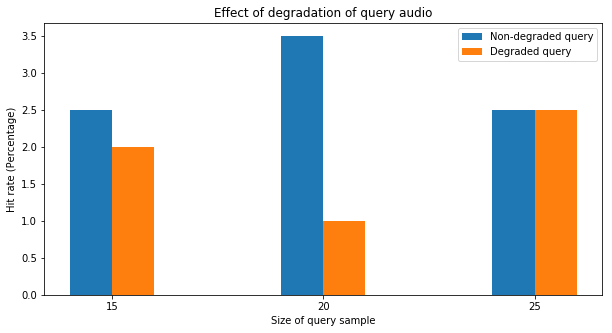

In [ ]:
y1 = np.array(hit_rate)
y2 = np.array(hit_rate_deg)
_X = np.arange(3)
plt.figure(figsize=[10,5])

plt.title("Effect of degradation of query audio")
plt.bar(_X - 0.1, y1*100.0/sample_size, 0.2,label="Non-degraded query")
plt.bar(_X + 0.1, y2*100.0/sample_size, 0.2,label="Degraded query")
plt.xticks(_X, CHUNK)
plt.xlabel("Size of query sample")
plt.ylabel("Hit rate (Percentage)")
plt.legend()
plt.show()

## Robustnes to pitch-shift and time-stretch

Pitch-shift and time-stretch is computed using the `audio_degrader` library. The effect of pitch-shift is tested for query samples computed with different pitch-shift factors. The chunk size of the query audio is 25 seconds. The hit rate observed are plotted.

In [ ]:
# Calculating the hit rate for audio degraded samples 
hit_rate_pitch_shift = []
src = '/gdrive/MyDrive/gtzan_genre'
FACTOR = [0.5,0.75,1,1.25,1.5]  # Pitch shift factor (multiplicative)
for i in range(5):
  hit = 0
  dirpath = sample_audio_chunks2(FACTOR[i], src + '/sampled_audio_pitch_shift_' + str(FACTOR[i]))
  for filename in os.listdir(dirpath):
    fp_q = qfp.QueryFingerprint(os.path.join(dirpath,filename))
    try:
      fp_q.create()
    except IndexError:
      continue
    database.query(fp_q)
    if len(fp_q.matches) != 0 and unicodedata.normalize('NFKD', fp_q.matches[0].record).encode('ascii', 'ignore') == filename:
      hit += 1
  hit_rate_pitch_shift.append(hit)

In [ ]:
hit_rate_pitch_shift

[0, 0, 0, 0, 0]

It appears from this implementation that there are no hits in the case of pitch-shifts. It is possible that this occurs due to problems with the way the library has been implemented.

In [ ]:
hit_rate_time_stretch = []
src = '/gdrive/MyDrive/gtzan_genre'
FACTOR = [0.5,0.75,1,1.25,1.5]  # Time stretch factor (multiplicative)
for i in range(5):
  hit = 0
  dirpath = sample_audio_chunks2(FACTOR[i], src + '/sampled_audio_time_stretch_' + str(FACTOR[i]))
  for filename in os.listdir(dirpath):
    fp_q = qfp.QueryFingerprint(os.path.join(dirpath,filename))
    try:
      fp_q.create()
    except IndexError:
      continue
    database.query(fp_q)
    if len(fp_q.matches) != 0 and unicodedata.normalize('NFKD', fp_q.matches[0].record).encode('ascii', 'ignore') == filename:
      hit += 1
  hit_rate_time_stretch.append(hit)

In [ ]:
hit_rate_time_stretch

[0, 0, 0, 0, 0]